In [ ]:
!pip install tensorflow==1.15 dm-sonnet==1.36 tensor2tensor==1.14

     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 665 kB 71.5 MB/s 
     |████████████████████████████████| 1.6 MB 55.5 MB/s 
     |████████████████████████████████| 3.8 MB 43.9 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 503 kB 69.3 MB/s 
     |████████████████████████████████| 2.5 MB 60.9 MB/s 
     |████████████████████████████████| 366 kB 60.6 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 5.8 MB 44.9 MB/s 
     |████████████████████████████████| 367 kB 57.4 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 191 kB 66.1 MB/s 
     |████████████████████████████████| 1.5 MB 58.8 MB/s 
     |████████████████████████████████| 1.6 MB 57.3 MB/s 
     |████████████████████████████████| 1.6 MB 64.0 MB/s 
     |████████████████████████████████| 1.6 MB 69.5 MB/s 
     |██████████████

In [ ]:
import time
import numpy as np
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # Hide TF deprecation messages
import matplotlib.pyplot as plt

%cd /tmp
%rm -rf /tmp/deepmind_research
!git clone https://github.com/deepmind/deepmind-research.git \
  /tmp/deepmind_research
%cd /tmp/deepmind_research/polygen
import modules
import data_utils

/tmp
Cloning into '/tmp/deepmind_research'...
remote: Enumerating objects: 2271, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (452/452), done.
remote: Total 2271 (delta 440), reused 624 (delta 389), pack-reused 1423
Receiving objects: 100% (2271/2271), 93.69 MiB | 28.00 MiB/s, done.
Resolving deltas: 100% (1101/1101), done.
/tmp/deepmind_research/polygen


In [ ]:
!mkdir /tmp/vertex_model
!mkdir /tmp/face_model
!gsutil cp gs://deepmind-research-polygen/vertex_model.tar.gz /tmp/vertex_model/
!gsutil cp gs://deepmind-research-polygen/face_model.tar.gz /tmp/face_model/
!tar xvfz /tmp/vertex_model/vertex_model.tar.gz -C /tmp/vertex_model/
!tar xvfz /tmp/face_model/face_model.tar.gz -C /tmp/face_model/

Copying gs://deepmind-research-polygen/vertex_model.tar.gz...
\ [1 files][278.2 MiB/278.2 MiB]                                                
Operation completed over 1 objects/278.2 MiB.                                    
Copying gs://deepmind-research-polygen/face_model.tar.gz...
| [1 files][337.0 MiB/337.0 MiB]                                                
Operation completed over 1 objects/337.0 MiB.                                    
model.data-00000-of-00001
checkpoint
model.index
model.data-00000-of-00001
checkpoint
model.index


In [ ]:
vertex_module_config=dict(
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=24,
      dropout_rate=0.4,
      re_zero=True,
      memory_efficient=True
      ),
  quantization_bits=8,
  class_conditional=True,
  max_num_input_verts=5000,
  use_discrete_embeddings=True,
  )

face_module_config=dict(
  encoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=10,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=14,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  class_conditional=False,
  decoder_cross_attention=True,
  use_discrete_vertex_embeddings=True,
  max_seq_length=8000,
  )

Generating samples...
Num. samples complete: 5
sampling time: 1805.2817604541779


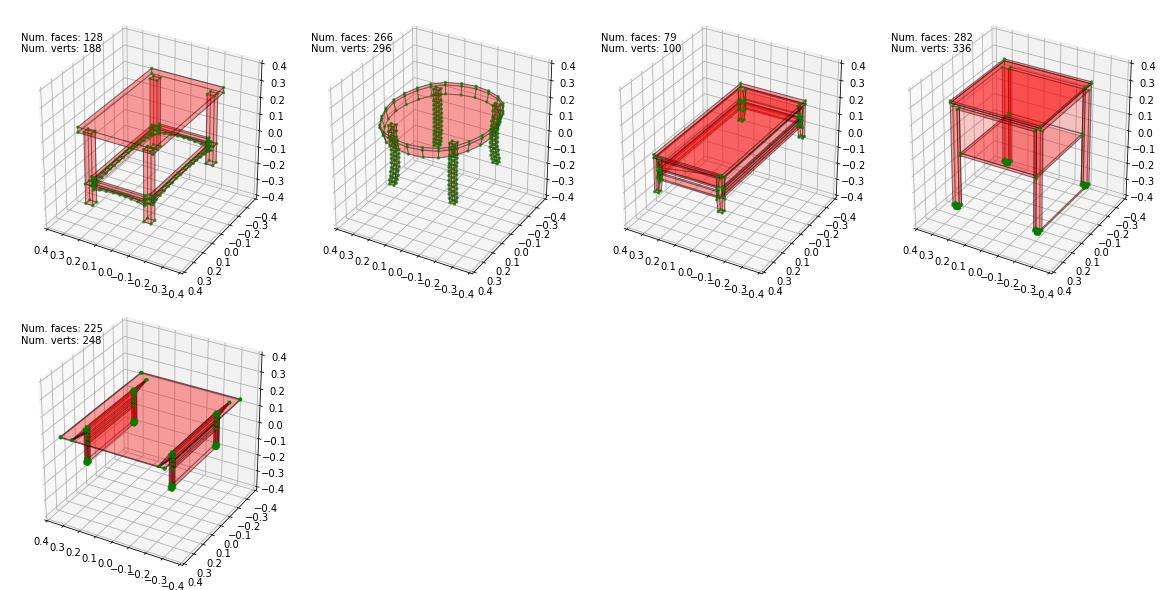

In [ ]:
class_id = '29) knife' #@param ['0) airplane,aeroplane,plane','1) ashcan,trash can,garbage can,wastebin,ash bin,ash-bin,ashbin,dustbin,trash barrel,trash bin','2) bag,traveling bag,travelling bag,grip,suitcase','3) basket,handbasket','4) bathtub,bathing tub,bath,tub','5) bed','6) bench','7) birdhouse','8) bookshelf','9) bottle','10) bowl','11) bus,autobus,coach,charabanc,double-decker,jitney,motorbus,motorcoach,omnibus,passenger vehi','12) cabinet','13) camera,photographic camera','14) can,tin,tin can','15) cap','16) car,auto,automobile,machine,motorcar','17) cellular telephone,cellular phone,cellphone,cell,mobile phone','18) chair','19) clock','20) computer keyboard,keypad','21) dishwasher,dish washer,dishwashing machine','22) display,video display','23) earphone,earpiece,headphone,phone','24) faucet,spigot','25) file,file cabinet,filing cabinet','26) guitar','27) helmet','28) jar','29) knife','30) lamp','31) laptop,laptop computer','32) loudspeaker,speaker,speaker unit,loudspeaker system,speaker system','33) mailbox,letter box','34) microphone,mike','35) microwave,microwave oven','36) motorcycle,bike','37) mug','38) piano,pianoforte,forte-piano','39) pillow','40) pistol,handgun,side arm,shooting iron','41) pot,flowerpot','42) printer,printing machine','43) remote control,remote','44) rifle','45) rocket,projectile','46) skateboard','47) sofa,couch,lounge','48) stove','49) table','50) telephone,phone,telephone set','51) tower','52) train,railroad train','53) vessel,watercraft','54) washer,automatic washer,washing machine']
num_samples_min = 1 #@param
num_samples_batch = 8 #@param
max_num_vertices = 400 #@param
max_num_face_indices = 2000 #@param
top_p_vertex_model = 0.9 #@param
top_p_face_model = 0.9 #@param

tf.reset_default_graph()

# Build models
vertex_model = modules.VertexModel(**vertex_module_config)
face_model = modules.FaceModel(**face_module_config)

# Tile out class label to every element in batch
class_id = int(class_id.split(')')[0])
vertex_model_context = {'class_label': tf.fill([num_samples_batch,], class_id)}
vertex_samples = vertex_model.sample(
    num_samples_batch, context=vertex_model_context, 
    max_sample_length=max_num_vertices, top_p=top_p_vertex_model, 
    recenter_verts=True, only_return_complete=True)
vertex_model_saver = tf.train.Saver(var_list=vertex_model.variables)

# The face model generates samples conditioned on a context, which here is
# the vertex model samples
face_samples = face_model.sample(
    vertex_samples, max_sample_length=max_num_face_indices, 
    top_p=top_p_face_model, only_return_complete=True)
face_model_saver = tf.train.Saver(var_list=face_model.variables)

# Start sampling
start = time.time()
print('Generating samples...')
with tf.Session() as sess:
  vertex_model_saver.restore(sess, '/tmp/vertex_model/model')
  face_model_saver.restore(sess, '/tmp/face_model/model')
  mesh_list = []
  num_samples_complete = 0
  while num_samples_complete < num_samples_min:
    v_samples_np = sess.run(vertex_samples)
    if v_samples_np['completed'].size == 0:
      print('No vertex samples completed in this batch. Try increasing ' +
            'max_num_vertices.')
      continue
    f_samples_np = sess.run(
        face_samples,
        {vertex_samples[k]: v_samples_np[k] for k in vertex_samples.keys()})
    v_samples_np = f_samples_np['context']
    num_samples_complete_batch = f_samples_np['completed'].sum()
    num_samples_complete += num_samples_complete_batch
    print('Num. samples complete: {}'.format(num_samples_complete))
    for k in range(num_samples_complete_batch):
      verts = v_samples_np['vertices'][k][:v_samples_np['num_vertices'][k]]
      faces = data_utils.unflatten_faces(
          f_samples_np['faces'][k][:f_samples_np['num_face_indices'][k]])
      mesh_list.append({'vertices': verts, 'faces': faces})
end = time.time()
print('sampling time: {}'.format(end - start))

data_utils.plot_meshes(mesh_list, ax_lims=0.4)  

In [ ]:
mesh_id = 4  #@param
data_utils.write_obj(
    mesh_list[mesh_id]['vertices'], mesh_list[mesh_id]['faces'], 
    'mesh-{}.obj'.format(mesh_id))